In [1]:
import pandas as pd

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [16]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

In [14]:
run all_functions.py


In [93]:
cat ../sensitivity-data/wm_All.json

{"wm": {"All": {"k": 1, "f": ["aggregate_11", "aggregate_10", "bet_500_1000", "daily_usage_1", "aggregate_2", "difference_min_max"], "accuracy": 66.39890569935929}}}

In [53]:
!ls -1 ../sensitivity-data|grep .json

dr_All.json
dr_Monthly+Static.json
dr_Monthly.json
dr_Static.json
dw_All.json
dw_Monthly+Static.json
dw_Monthly.json
dw_Static.json
fridge_All.json
fridge_Monthly+Static.json
fridge_Monthly.json
fridge_Static.json
hvac_All.json
hvac_Monthly+Static.json
hvac_Monthly.json
hvac_Static.json
light_All.json
light_Monthly+Static.json
light_Monthly.json
light_Static.json
wm_All.json
wm_Monthly+Static.json
wm_Monthly.json
wm_Static.json


In [28]:
appliances = ["hvac","dr", "light","fridge","wm","dw"]
out = {}
import json
for appliance in appliances:
    out[appliance]={}
    for feature in ["Monthly","Static", "Monthly+Static","All"]:
        print appliance, feature
        out[appliance][feature]={}
        o = json.load(open("../sensitivity-data/%s_%s.json" %(appliance, feature),'r'))
        f = o[appliance][feature]['f']
        k = o[appliance][feature]['k']
        temp= create_predictions(df, dfc, all_homes, appliance_min, 
                                              national_average, appliance=appliance,
                                                feature=f, NUM_NEIGHBOURS=k,
                                                   train_outlier=True, test_outlier=False, 
                                                outlier_features=None,
                                                outlier_fraction=0.1)
        errors = {}
        if appliance =="hvac":
            start_month, end_month = 5, 11
        else:
            start_month, end_month = 1, 13
        for i in range(start_month, end_month):
            errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
            error_df = pd.DataFrame(errors)
            accur_df = 100-error_df
            accur_df[accur_df<0]=0

        tdf = accur_df
        if appliance =="hvac":
            for home in [624, 1953, 6636, 6836, 7769, 9922]:
                tdf.loc[home, 5]=np.NaN
                tdf.loc[home, 10]=np.NaN

        out[appliance][feature]=tdf.T.mean().mean()
            
            

hvac Monthly
hvac Static
hvac Monthly+Static
hvac All
dr Monthly
dr Static
dr Monthly+Static
dr All
light Monthly
light Static
light Monthly+Static
light All
fridge Monthly
fridge Static
fridge Monthly+Static
fridge All
wm Monthly
wm Static
wm Monthly+Static
wm All
dw Monthly
dw Static
dw Monthly+Static
dw All


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
appliance_name_mapping = {"dr": "Dryer", "wm": "Washing\nmachine",
                          "fridge":"Fridge","light":"Lights",
                          "hvac":"HVAC","dw":"Dish\nwasher"}

In [56]:
sen = pd.DataFrame(out)

In [55]:
# Adding orcale

In [57]:
sen

,dr,dw,fridge,hvac,light,wm
All,41.500556,46.288463,81.597182,79.283312,53.255072,66.398906
Monthly,39.344495,42.587760,77.740660,79.208159,47.066094,64.363110
Monthly+Static,41.720212,42.077928,78.442603,79.208159,49.605087,64.504250
Static,38.444273,38.623122,75.182587,71.783518,48.235812,60.045676


In [58]:
sen.loc['Oracle'] = pd.Series({'dr': 64.885914164535222,
 'dw': 61.017474093337341,
 'fridge': 91.888765437104055,
 'hvac': 93.195959529260662,
 'light': 77.810755698772141,
 'wm': 80.183453230991176})

In [60]:
sen = sen.ix[['Static','Monthly','Monthly+Static','All','Oracle']]

In [61]:
sen = sen.rename(columns=appliance_name_mapping).T

In [62]:
sen

,Static,Monthly,Monthly+Static,All,Oracle
Dryer,38.444273,39.344495,41.720212,41.500556,64.885914
Dish\nwasher,38.623122,42.587760,42.077928,46.288463,61.017474
Fridge,75.182587,77.740660,78.442603,81.597182,91.888765
HVAC,71.783518,79.208159,79.208159,79.283312,93.195960
Lights,48.235812,47.066094,49.605087,53.255072,77.810756
Washing\nmachine,60.045676,64.363110,64.504250,66.398906,80.183453


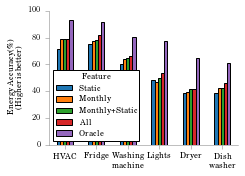

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
from common_functions import latexify, format_axes
latexify(columns=1, fig_height=2.4)

tableau20blind =  [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Rescale to values between 0 and 1
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
    

sen.ix[['HVAC','Fridge','Washing\nmachine',
                                    'Lights','Dryer','Dish\nwasher']].plot(kind="bar",rot=0, colors=tableau20blind[::2])
format_axes(plt.gca())
plt.ylim((0,100))
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)");
plt.legend(loc=3, title="Feature")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity-features.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity-features.png",bbox_inches="tight")

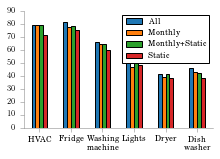